In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
%matplotlib notebook
from scipy import *
from tqdm.notebook import *
import sys
import os
import seaborn as sns
sns.set_theme(style="whitegrid")
import time
from numba import jit
from numpy import imag
from scipy import signal
import pandas as pd

import seaborn
sns.color_palette("muted")
color_scheme = sns.color_palette("Paired")

color_scheme

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

# Measuring particles properties

In [2]:
dt = 10**(-4)

In [3]:
def load_data(data_dir, npoints, remove):  
    #path_files_TD = [f for f in os.listdir(data_dir) if f.endswith('.dat')]  # search forlder for data files
        
    # sort the datasets by order of the particles
    #path_files_TD=sorted(path_files_TD)
        
    #store the info for each file
    x_windows = [] #xdata  
    y_windows = [] #ydata
    zsum_windows = [] #intensity data
    
    nsegments_min = []
    
    #current_dir = "".join((data_dir,path_files_TD[file]))
        
    current_df = pd.read_csv(data_dir,skiprows=2,header=None,delimiter='\t')
        
    # [files, segments, timeseries]
    x_windows.append(current_df[0])
    y_windows.append(current_df[1])
    zsum_windows.append(current_df[2])        
        
    # free memory
    del current_df
    
    print(">>> len of time windows" + str(len(x_windows[0])))
    data = np.zeros((3, 1, 1, len(x_windows[0])))

    # Mean centering of the position points referencing to the mean position value of each segment

    data[0,0,0] = x_windows - np.mean(x_windows)
    data[1,0,0] = y_windows - np.mean(y_windows)
    data[2,0,0] = zsum_windows - np.mean(zsum_windows)
    
    # free memory
    del x_windows
    del y_windows
    del zsum_windows
    
    #print(targets)
    # loops to remove particles from the set. this way we can limit the study to the remaining particles
    return data

In [107]:
# Data folder directory
targets = "3umPS"
particle = 8
exp_data_dir = "./Data/1st article data/Synthetic particles/" + str(targets) + str(particle)+".dat"

# histogram time integration
npoints = int(50000*5)

remove = ["3umPMMA", "4umPS", "8umPMMA", "8umPS", "water"]  # particles to be removed from the set

In [108]:
# load experimental position timeseries
timeseries = load_data(exp_data_dir, npoints, remove)

print(timeseries.shape)

>>> len of time windows336000
(3, 1, 1, 336000)


### Standard deviation:

In [110]:
C = 1.5*10**(-6)  # m/V

In [112]:
sys.path.append("./Calibration/std_dev")  # add folder with calibration scripts

import std_dev as sd  # import the potential analysis script

print(timeseries.shape)

conversion_constant = 1.5*10**(-6)  # conversion constant between Volt and meter
diff = np.array([1.,1.,1.])
gama = 1.38*10**(-23) * conversion_constant**(-2) * 300.  # boltzmann constant time conversion factor times room temperature

k_estimate_experimental, k_var, x_eq = sd.main(timeseries[:2,0,:], gama, diff)

print((k_estimate_experimental).T , r'$\pm$', np.sqrt(k_var))
print(x_eq)

(3, 1, 1, 336000)
[2.89937822e-06 6.22781057e-06] $\pm$ [0.02519164 0.01718863]
[1.15727533e-17 3.40805426e-17]


### PSD:

In [114]:
import scipy as sp
from scipy.optimize import curve_fit
from importlib import reload

T = gama*diff

sys.path.append("./Calibration/Power Spectral Density")
import PSD as PSD
PSD = reload(PSD)

nperseg = int(timeseries.shape[3]/10)

psd_experimental, freqs_experimental, p_experimental, p_cov = PSD.main(timeseries[:,0,:], dt, nperseg, 2)

print("Diff = " + str(p_experimental[0]))
print("fp = " + str(p_experimental[1]))

(2, 1, 16801)
(16801,)
(2, 1, 16801)
(16801,)
Diff = [0.22406787 0.09504132]
fp = [91.46767593 72.79541027]


In [115]:
gama_experimental = k_estimate_experimental/(2*np.pi*p_experimental[1])
print(r">>> $\gamma = $", str(p_experimental[1]))

diff_experimental = p_experimental[0]

>>> $\gamma = $ [91.46767593 72.79541027]


# Simulation

In [116]:
#### system parameters

# particle param.:
density = 1.0 *C**3 * 10**6 *10**-3  # kg/V^3
radius = 3. *10**(-6) /C # V

m = (4/3)*np.pi*density * radius**3

# simulation parameters
N = 1
L = 2**23
dimensions = 2

fp=k_estimate_experimental/m
fm=gama_experimental/m

delta_t = 10**(-2)

fp = k_estimate_experimental/m
fm = gama_experimental/m

In [117]:
# RK4
sys.path.append("./Simulation/")
import brownian_motion_sim_adimensional as sim

import time

theta = 0.*np.pi/180

start = time.time()
data = sim.main(fp, fm, diff_experimental, N, L, delta_t, acquisition_rate=10**(-4), naxis=dimensions, theta=theta)  # run rk4 integrator
stop = time.time()
print(stop-start)

>>> Each time step mean elapsed time = 0.0
(4, 1, 8388608)
15.072964191436768


# PSD comparison

In [118]:
T = gama*diff

print(data.shape)

nperseg = int(data.shape[2]/1000)

psd, freqs, p, p_cov = PSD.main(data[:,:,::], delta_t, nperseg, 2)

print("Diff = " + str(p[0]))
print("fp = " + str(p[1]))

(2, 1, 8388608)
(2, 1, 4195)
(4195,)
(2, 1, 4195)
(4195,)
Diff = [3.31342605e-08 9.51108278e-08]
fp = [0.00138332 0.00284996]


In [119]:
k_estimate, k_var, x_eq = sd.main(data[:,:,:], gama_experimental, diff_experimental)

In [120]:
print(p_experimental)
print(p)
print(k_estimate_experimental)
print(k_estimate)

[[ 0.22406787  0.09504132]
 [91.46767593 72.79541027]]
[[3.31342605e-08 9.51108278e-08]
 [1.38331614e-03 2.84996450e-03]]
[2.89937822e-06 6.22781057e-06]
[5.06099143e-06 3.76651455e-06]


In [121]:
gama = k_estimate/(2*np.pi*p[1])
print(r">>> $\gamma = $", str(p[1]))

diff = p[0]

>>> $\gamma = $ [0.00138332 0.00284996]


# MSD

In [41]:
def MSD(timeseries, N=100000, M=2000000):  # N is the maximum multiple of time interval to compute
    time_intervals = np.arange(1, N+1, 1)
    
    msd = np.zeros((timeseries.shape[0],timeseries.shape[1],time_intervals.shape[0]))
    
    for i in range(time_intervals.shape[0]):
        msd[:,:,i] = np.mean((timeseries[:,:,i:i+M]-timeseries[:,:,:M])**2, axis=2)
        
    return msd
    
    

In [42]:
msd = MSD(data[:,:,:])

In [43]:
msd_exp = MSD(timeseries[:2,particle], N=1000, M=240000)

<IPython.core.display.Javascript object>


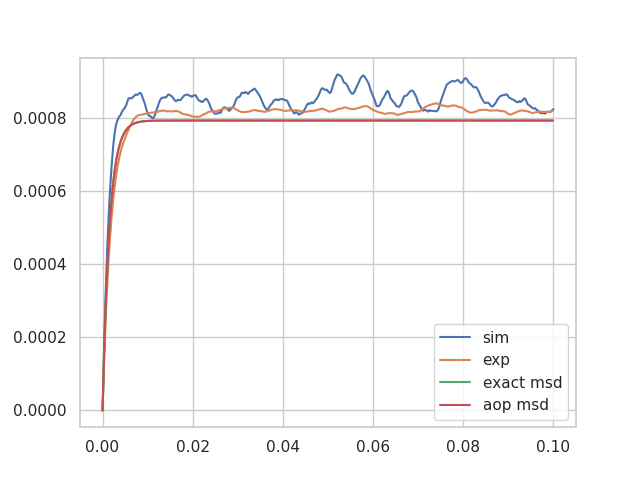

In [49]:
fig, axs = subplots(1)

axs.plot(np.arange(0,100000,1)*10**-6, msd[0,0], label="sim")

wM = 0.5*(-fm[0] + np.sqrt((fm[0])**2 - 4*fp[0]))
wm = 0.5*(-fm[0] - np.sqrt((fm[0])**2 - 4*fp[0]))

#wM = 0.5*(-gama[0]/m + np.sqrt((gama[0]/m)**2 - 4*k_estimate[0]/m))
#wm = 0.5*(-gama[0]/m - np.sqrt((gama[0]/m)**2 - 4*k_estimate[0]/m))

def msd_exact(time, wM, wm, fm, diff):
    return 2*fm *diff/(wM-wm) *(-(1.-np.exp(wM*time))/wM + (1.-np.exp(wm*time))/wm)

def msd_app(time, gama, diff, k):
    return 2*gama*diff*(1.-np.exp(-time*k/gama))/k

axs.plot(np.arange(0,1000,1)*10**-4, msd_exp[0,0], label="exp")
axs.plot(np.arange(0,1000,1)*10**-4, msd_exact(np.arange(0,1000,1)*10**-4, wM, wm, fm[0], diff_experimental[0]), label="exact msd")
axs.plot(np.arange(0,1000,1)*10**-4, msd_app(np.arange(0,1000,1)*10**-4, gama_experimental[0], diff_experimental[0], k_estimate_experimental[0]), label="aop msd")

axs.legend()

# MSD density distribution

<IPython.core.display.Javascript object>


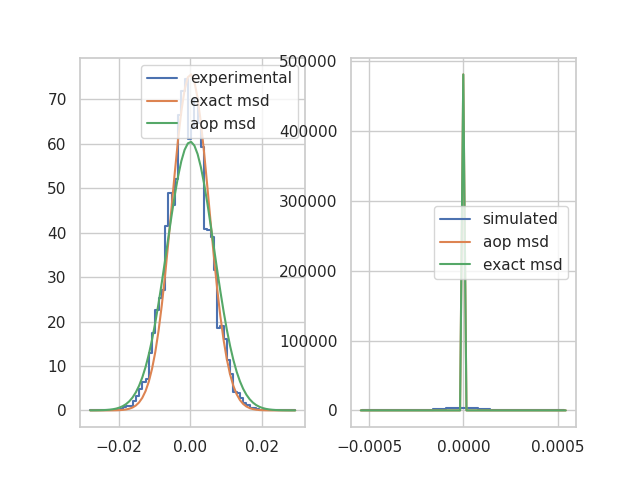

(2, 1, 8388608)
(3, 1, 1, 336000)


In [156]:
def normal(x, x0, var):
    return np.exp(-0.5*(x-x0)**2 /var)/np.sqrt(2*np.pi*var)

def msd_exact(time, wM, wm, fm, diff):
    return 2*fm *diff/(wM-wm) *(-(1.-np.exp(wM*time))/wM + (1.-np.exp(wm*time))/wm)

fig, axs = subplots(1,2)

hist, bins = np.histogram(data[0,0,1:]-data[0,0,:-1], 64, density=True)

bin = (bins[1:]+bins[:-1])/2
axs[1].step(bin, hist, label="simulated")

x = np.linspace(np.min(data[0,0,1:]-data[0,0,:-1]), np.max(data[0,0,1:]-data[0,0,:-1]),100)
#axs[1].plot(bins, normal(bins, np.mean(data[0,0,1:]-data[0,0,:-1]), np.var(data[0,0,1:]-data[0,0,:-1])))
axs[1].plot(bins, normal(bins, 0., msd_app(10**-6, gama[0], diff[0], k_estimate[0])),label="aop msd")
axs[1].plot(bins, normal(bins, 0., msd_exact(10**-6, 0.5*(-gama[0]/m + np.sqrt((gama[0]/m)**2 - 4*k_estimate[0]/m)), 0.5*(-gama[0]/m - np.sqrt((gama[0]/m)**2 - 4*k_estimate[0]/m)), gama[0]/m, diff[0])),label="exact msd")

hist, bins = np.histogram(timeseries[0,0,0,1:]-timeseries[0,0,0,:-1], 64, density=True)
bins = (bins[1:]+bins[:-1])/2
axs[0].step(bins, hist,label="experimental")

x = np.linspace(np.min(timeseries[0,0,0,1:]-timeseries[0,0,0,:-1]), np.max(timeseries[0,0,0,1:]-timeseries[0,0,0,:-1]),100)
#axs[0].plot(bins, normal(bins, np.mean(timeseries[0,0,0,1:]-timeseries[0,0,0,:-1]), np.var(timeseries[0,0,0,1:]-timeseries[0,0,0,:-1])))
axs[0].plot(bins, normal(bins, 0., msd_exact(10**-4, wM, wm, fm[0], diff_experimental[0])),label="exact msd")
axs[0].plot(bins, normal(bins, 0., msd_app(10**-4, gama_experimental[0], diff_experimental[0], k_estimate_experimental[0])),label="aop msd")

axs[0].legend()
axs[1].legend()

print(data.shape)
print(timeseries.shape)